In [151]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SequentialFeatureSelector

In [80]:
df = pd.read_csv('/Users/peugene/Library/CloudStorage/OneDrive-Synopsys,Inc/Documents/study/Berkeley/capstone/data/GregaVrbancic/dataset_full.csv') 

In [3]:
df.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


## EDA and Data Check

In [81]:
#no categorical values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88647 entries, 0 to 88646
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 75.7 MB


In [5]:
#no missing values
assert df.isna().agg(sum).sum() == 0

In [67]:
#checking for dulplicate rows
df.duplicated().sum()

1438

In [82]:
#dropping duplicate rows
df = df.drop_duplicates(keep=False)

In [83]:
assert df.duplicated().sum() == 0

In [84]:
df.shape

(86721, 112)

In [28]:
#moderately imbalanced dataset
df.phishing.value_counts(normalize=True)

phishing
0    0.649035
1    0.350965
Name: proportion, dtype: float64

**?? The dataset has a high degree of multicollinearity, however, as I understand it's not a problem for NN, Dtree, random forest. The question is should just use those models (decision tree in fact performs very well) or should I take a path of dealing with multicollinearity?**

In [11]:
#corr_matrix = df.corr()

In [22]:
#threshold = 0.8

In [23]:
# Create a mask to ignore self-correlations (diagonal) and lower triangle
#mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

In [24]:
#Extract pairs of features with correlation greater than the threshold
#high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                   #for i, j in zip(*np.where((np.abs(corr_matrix) > threshold) & mask))]

In [25]:
#high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

In [27]:
#high_corr_df

**The vast majority of the data looks like this**

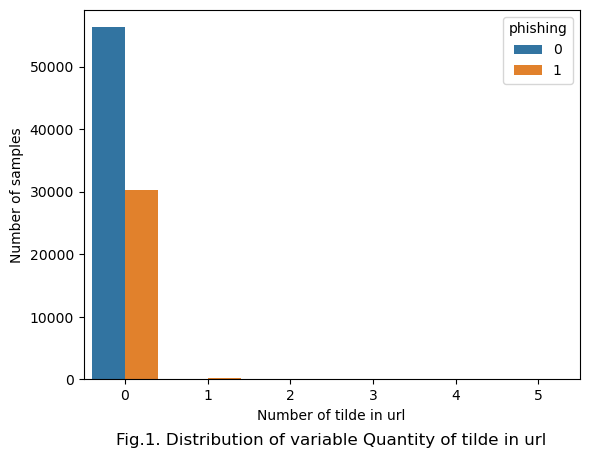

In [154]:
sns.countplot(df, x='qty_tilde_url', hue='phishing')
plt.ylabel("Number of samples")
plt.xlabel("Number of tilde in url")
plt.title("Fig.1. Distribution of variable Quantity of tilde in url", x=0.5, y=-0.2)
plt.savefig('1.png')

## Data prep

In [76]:
X = df.drop(labels=["phishing"], axis=1)
y = df["phishing"]

In [32]:
#train/test splitting with stratify option
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape

((69376, 111), (17345, 111))

In [33]:
#standard scaling
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## About accuracy metric

For this dataset, a false positive will be observed when a model labels a normal site as malicious. A false negative will be observed when a model labels a malicious site. False negatives are more dangerous as a user will trust a malicious site. Therefore, we will be using recall score.

## Aplying models

**Dummy classifier**

In [35]:
#We will use a sklearn dummy classifier to establish a baseline
dummy_clf = DummyClassifier(strategy="prior")

In [36]:
dummy_clf.fit(X_train_scaled, y_train)

DummyClassifier()

In [37]:
y_pred_test = dummy_clf.predict(X_test_scaled)
y_pred_train = dummy_clf.predict(X_train_scaled)

In [38]:
#the dummy classifer predicts no instance of 1 class, therefore we can't really calculate false negative rate or 
#recall score
np.unique(y_pred_test)

array([0])

In [39]:
#we can look at the classification report to confirm that
report = classification_report(y_test, y_pred_test, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.65      1.00      0.79     11258
           1       0.00      0.00      0.00      6087

    accuracy                           0.65     17345
   macro avg       0.32      0.50      0.39     17345
weighted avg       0.42      0.65      0.51     17345



**Logistic regression**

In [40]:
log_reg = LogisticRegression(max_iter=10000)

In [41]:
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=10000)

In [42]:
y_pred_test_log = log_reg.predict(X_test_scaled)
y_pred_train_log = log_reg.predict(X_train_scaled)

In [43]:
recall_test_log = recall_score(y_test, y_pred_test_log)
recall_train_log = recall_score(y_train, y_pred_train_log)

In [49]:
print("Test set recall score: ", round(recall_test_log, 3))
print("Train set recall score: ", round(recall_train_log, 3))

Test set recall score:  0.917
Train set recall score:  0.916


**KNN**

In [45]:
knn = KNeighborsClassifier()

In [46]:
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [47]:
y_pred_test_knn = knn.predict(X_test_scaled)
y_pred_train_knn = knn.predict(X_train_scaled)

In [50]:
recall_test_knn = recall_score(y_test, y_pred_test_knn)
recall_train_knn = recall_score(y_train, y_pred_train_knn)

In [51]:
print("Test set recall score: ", round(recall_test_knn, 3))
print("Train set recall score: ", round(recall_train_knn, 3))

Test set recall score:  0.933
Train set recall score:  0.949


**Decision Tree**

In [52]:
decision_tree = DecisionTreeClassifier()

In [53]:
decision_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [54]:
y_pred_test_tree = decision_tree.predict(X_test_scaled)
y_pred_train_tree = decision_tree.predict(X_train_scaled)

In [55]:
recall_test_tree = recall_score(y_test, y_pred_test_tree)
recall_train_tree = recall_score(y_train, y_pred_train_tree)

In [56]:
print("Test set recall score: ", round(recall_test_tree, 3))
print("Train set recall score: ", round(recall_train_tree, 3))

Test set recall score:  0.93
Train set recall score:  1.0


**SVM**

In [57]:
svc = SVC()

In [58]:
svc.fit(X_train_scaled, y_train)

SVC()

In [59]:
y_pred_test_svm = svc.predict(X_test_scaled)
y_pred_train_svm = svc.predict(X_train_scaled)

In [60]:
recall_test_svm = recall_score(y_test, y_pred_test_svm)
recall_train_svm = recall_score(y_train, y_pred_train_svm)

In [61]:
print("Test set precision score: ", round(recall_test_svm, 3))
print("Train set precision score: ", round(recall_train_svm, 3))

Test set precision score:  0.929
Train set precision score:  0.93


## Tuning the model

In [127]:
param_grid_knn = {
    'n_neighbors': [18, 19, 20, 21, 22],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [128]:
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='recall')

In [129]:
grid_search_knn.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [18, 19, 20, 21, 22],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [130]:
best_knn = grid_search_knn.best_estimator_

In [131]:
y_pred_test_knn_g = best_knn.predict(X_test_scaled)
y_pred_train_knn_g = best_knn.predict(X_train_scaled)

In [132]:
recall_test_knn_g = recall_score(y_test, y_pred_test_knn_g)
recall_train_knn_g = recall_score(y_train, y_pred_train_knn_g)

In [133]:
print("Best parameters found: ", grid_search_knn.best_params_)

Best parameters found:  {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


In [134]:
print("Test set recall score: ", round(recall_test_knn_g, 3))
print("Train set recall score: ", round(recall_train_knn_g, 3))

Test set recall score:  0.931
Train set recall score:  1.0


## Feature selection

In [139]:
sfs = SequentialFeatureSelector(knn, n_features_to_select=10, direction='backward', scoring='recall')

In [143]:
pipeline = Pipeline([
    ('feature_selection', sfs),
    ('KNN', knn)
])

In [144]:
pipeline.fit(X_train_scaled, y_train)

Pipeline(steps=[('feature_selection',
                 SequentialFeatureSelector(direction='backward',
                                           estimator=KNeighborsClassifier(),
                                           n_features_to_select=10,
                                           scoring='recall')),
                ('KNN', KNeighborsClassifier())])

In [145]:
y_pred_test_knn_2 = pipeline.predict(X_test_scaled)
y_pred_train_knn_2 = pipeline.predict(X_train_scaled)

In [146]:
recall_test_knn_2 = recall_score(y_test, y_pred_test_knn_2)
recall_train_knn_2 = recall_score(y_train, y_pred_train_knn_2)

In [147]:
print("Test set recall score: ", round(recall_test_knn_2, 3))
print("Train set recall score: ", round(recall_train_knn_2, 3))

Test set recall score:  0.906
Train set recall score:  0.947


In [148]:
selected_features = sfs.get_support(indices=True)

In [149]:
print(f'Selected Features: {X.columns[selected_features].tolist()}')

Selected Features: ['qty_slash_url', 'qty_dot_domain', 'qty_vowels_domain', 'qty_dot_directory', 'qty_underline_file', 'domain_spf', 'time_domain_activation', 'qty_ip_resolved', 'qty_mx_servers', 'tls_ssl_certificate']
